In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import shutil
import os
from scipy.stats import zscore
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from collections import OrderedDict
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)
    
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [3]:
path = "./data/"
    
filename = os.path.join(path,"Stock_Price_MAX.csv")
df = pd.read_csv(filename, na_values=['NA','?'])

df_work=df.drop(columns=['Date','Adj_Close'], axis=1)

<h4>Feature Normalization</h4>

In [4]:
df_work['Open']=zscore(df_work['Open'])
df_work['High'] = zscore(df_work['High'])
df_work['Low'] = zscore(df_work['Low'])
df_work['Volume'] = zscore(df_work['Volume'])

x1 = df_work['Open'].values.reshape( len(df['Open']),1)
x2 = df_work['High'].values.reshape( len(df['High']),1)
x3 = df_work['Low'].values.reshape( len(df['Low']),1)
x4 = df_work['Volume'].values.reshape( len(df['Volume']),1)


<h3>Task 1: Use the daily [Open, High, Low, Volume] to predict [Close] on that day using a fully-connected neural network. Use the first 70% of the records for training and the remaining 30% of the records for test. Report the RMSE of the model. Show the “regression lift chart” of your test data.</h3>

In [5]:
import math as Math
x = np.concatenate([x1,x2,x3,x4],axis=1)
y = df_work['Close']
# Split into train/test
train_set_size = x.shape[0] * 0.70
train_set_size = Math.ceil(train_set_size)

x_train = x[0:train_set_size]
x_test = x[train_set_size+1 : x.shape[0]]
y_train = y[0:train_set_size]
y_test = y[train_set_size+1 : x.shape[0]]

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense,Dropout
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt


model = Sequential()
model.add(Dense(73, input_dim=x.shape[1], activation='relu'))
model.add(Dense(108, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(45, activation='relu'))
model.add(Dense(37, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')  
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto') 
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) 


Using TensorFlow backend.


In [7]:
for nn in range(3):
    model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=1000)  
    model.load_weights('best_weights.hdf5')
    pred = model.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Final score (RMSE): {}".format(score))
    score = r2_score(y_test, pred)  
    print(score)

Train on 3075 samples, validate on 1316 samples
Epoch 1/1000
3075/3075 [==============================] - 1s 233us/step - loss: 209.4054 - val_loss: 2102.2073
Epoch 2/1000
3075/3075 [==============================] - 0s 49us/step - loss: 24.7997 - val_loss: 343.9871
Epoch 3/1000
3075/3075 [==============================] - 0s 52us/step - loss: 4.3561 - val_loss: 16.8568
Epoch 4/1000
3075/3075 [==============================] - 0s 48us/step - loss: 1.0764 - val_loss: 0.8595
Epoch 5/1000
3075/3075 [==============================] - 0s 48us/step - loss: 0.8409 - val_loss: 1.0387
Epoch 6/1000
3075/3075 [==============================] - 0s 51us/step - loss: 0.6869 - val_loss: 3.6787
Epoch 7/1000
3075/3075 [==============================] - 0s 53us/step - loss: 0.7398 - val_loss: 1.0893
Epoch 8/1000
3075/3075 [==============================] - 0s 56us/step - loss: 0.7694 - val_loss: 4.1677
Epoch 9/1000
3075/3075 [==============================] - 0s 52us/step - loss: 0.6550 - val_loss: 2.06

3075/3075 [==============================] - 0s 62us/step - loss: 0.9524 - val_loss: 0.9840
Epoch 3/1000
3075/3075 [==============================] - 0s 56us/step - loss: 0.5442 - val_loss: 0.8516
Epoch 4/1000
3075/3075 [==============================] - 0s 61us/step - loss: 0.4248 - val_loss: 0.4845
Epoch 5/1000
3075/3075 [==============================] - 0s 55us/step - loss: 0.4300 - val_loss: 0.3862
Epoch 6/1000
3075/3075 [==============================] - 0s 60us/step - loss: 0.5172 - val_loss: 1.2924
Epoch 7/1000
3075/3075 [==============================] - 0s 56us/step - loss: 0.4304 - val_loss: 4.7676
Epoch 8/1000
3075/3075 [==============================] - 0s 57us/step - loss: 0.4319 - val_loss: 1.7186
Epoch 9/1000
3075/3075 [==============================] - 0s 53us/step - loss: 0.5056 - val_loss: 5.5197
Epoch 10/1000
3075/3075 [==============================] - 0s 50us/step - loss: 0.5196 - val_loss: 0.6008
Epoch 11/1000
3075/3075 [==============================] - 0s 52us/

3075/3075 [==============================] - 0s 51us/step - loss: 0.3450 - val_loss: 2.8019
Epoch 26/1000
3075/3075 [==============================] - 0s 51us/step - loss: 0.4260 - val_loss: 0.3184
Epoch 27/1000
3075/3075 [==============================] - 0s 54us/step - loss: 0.3851 - val_loss: 0.3582
Epoch 28/1000
3075/3075 [==============================] - 0s 55us/step - loss: 0.2917 - val_loss: 12.9968
Epoch 29/1000
3075/3075 [==============================] - 0s 49us/step - loss: 0.5546 - val_loss: 7.9612
Epoch 30/1000
3075/3075 [==============================] - 0s 49us/step - loss: 0.3690 - val_loss: 3.1249
Epoch 31/1000
3075/3075 [==============================] - 0s 47us/step - loss: 0.3032 - val_loss: 0.5110
Epoch 32/1000
3075/3075 [==============================] - 0s 48us/step - loss: 0.2807 - val_loss: 0.3665
Epoch 33/1000
3075/3075 [==============================] - 0s 51us/step - loss: 0.3328 - val_loss: 0.5525
Epoch 34/1000
3075/3075 [==============================] - 

<h4>Regression Lift Chart</h4>

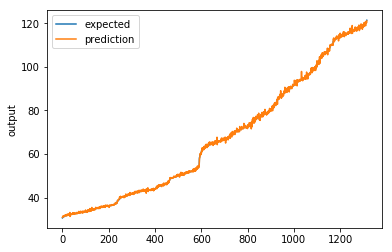

In [8]:
y_test_array = y_test.values.reshape( len(y_test),1)
pred_list=pred.flatten()

y_test_list = y_test_array.flatten()
chart_regression(pred_list,y_test_list)

<h3>Task 2: Predict [Close] of a day based on the last 7 days’ data [Open, High, Low, Volume, Close] using a LSTM model. In other words, we want to predict the price in the green cell using all the numbers in the red cell. Use the first 70% of the available records for training and the remaining 30% of the available records for test. Report the RMSE of the model. Show the “regression lift chart” of your test data.
Hint: Each record in X can be viewed as a sequence of 7 vectors, each vector with 5 dimensions.</h3>

In [9]:
df=df.drop(columns=['Date','Adj_Close'], axis=1)

In [10]:
df_work['Close'] = zscore(df_work['Close'])
x5 = df_work['Close'].values.reshape( len(df['Close']),1)

In [11]:
train_set_size = df_work.shape[0] * 0.70
train_set = Math.ceil(train_set_size)
df_train = df_work[0:train_set]
df_test = df_work[train_set+1 : df_work.shape[0]]

close_train = df_train.values
close_test = df_test.values
train_unnormalise_close = df[0:train_set]
test_unnormalise_close = df[train_set+1 : df_work.shape[0]]
train_unnormalise_close = train_unnormalise_close['Close'].tolist()
test_unnormalise_close =test_unnormalise_close['Close'].tolist()

print("Training set has {} records.".format(len(close_train)))
print("Test set has {} records.".format(len(close_test)))


Training set has 3075 records.
Test set has 1316 records.


In [12]:
import numpy as np

def to_sequences(seq_size, data, target):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        window = data[i:(i+SEQUENCE_SIZE)]
        window = [x for x in window]
        x.append(window)
        y.append(target[i+SEQUENCE_SIZE])
        
    return np.array(x),np.array(y)

In [13]:
SEQUENCE_SIZE = 7

x_train,y_train = to_sequences(SEQUENCE_SIZE,close_train,train_unnormalise_close)
x_test,y_test = to_sequences(SEQUENCE_SIZE,close_test,test_unnormalise_close)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (3067, 7, 5)
Shape of x_test: (1308, 7, 5)
Shape of y_train: (3067,)
Shape of y_test: (1308,)


In [14]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, Dropout
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
import numpy as np

print('Build model...')
model = Sequential()

model.add(LSTM(300, dropout=0.1, recurrent_dropout=0.1,input_shape=(SEQUENCE_SIZE, 5)))
model.add(Dense(225, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(150, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model


Build model...


In [15]:
for rnn in range(1):
    print('Train...')
    print("Itiration: {}".format(rnn))
    model.fit(x_train,y_train,
              validation_data=(x_test,y_test),
              callbacks=[monitor,checkpointer],verbose=2, epochs=500)
    model.load_weights('best_weights.hdf5')
    pred = model.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Score (RMSE): {}".format(score))
    score = r2_score(y_test, pred)  
    print("Score (R2): {}".format(score))

Train...
Itiration: 0
Train on 3067 samples, validate on 1308 samples
Epoch 1/500
 - 3s - loss: 52.0394 - val_loss: 1213.2607
Epoch 2/500
 - 1s - loss: 13.6251 - val_loss: 980.7303
Epoch 3/500
 - 2s - loss: 9.8346 - val_loss: 961.6707
Epoch 4/500
 - 1s - loss: 8.4506 - val_loss: 655.2966
Epoch 5/500
 - 1s - loss: 6.6154 - val_loss: 746.3639
Epoch 6/500
 - 1s - loss: 5.9265 - val_loss: 850.2504
Epoch 7/500
 - 1s - loss: 5.3406 - val_loss: 678.7283
Epoch 8/500
 - 1s - loss: 4.2616 - val_loss: 623.5545
Epoch 9/500
 - 1s - loss: 4.1659 - val_loss: 494.0193
Epoch 10/500
 - 1s - loss: 4.0426 - val_loss: 578.7652
Epoch 11/500
 - 2s - loss: 3.4329 - val_loss: 595.9022
Epoch 12/500
 - 2s - loss: 3.2132 - val_loss: 421.9754
Epoch 13/500
 - 1s - loss: 3.1315 - val_loss: 848.5853
Epoch 14/500
 - 1s - loss: 3.1390 - val_loss: 422.9198
Epoch 15/500
 - 1s - loss: 2.8092 - val_loss: 455.5225
Epoch 16/500
 - 1s - loss: 2.7291 - val_loss: 345.7560
Epoch 17/500
 - 1s - loss: 2.6097 - val_loss: 599.6975
E

<h4>Regression Lift Chart</h4>

(1308, 1)
(1308,)


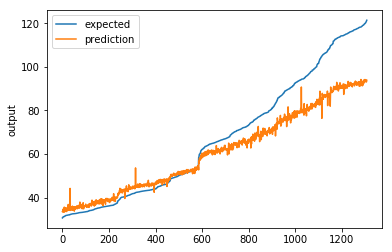

In [16]:
print(pred.shape)
print(y_test.shape)
pred_list=pred.flatten()
chart_regression(pred_list,y_test)

<h3>Task 3: Do the same as Task 2 but use a CNN model. Report the RMSE of the model. Show the “regression lift chart” of your test data.</h3>

In [17]:
def cnn_to_sequences(seq_size, data, target):
    x = []
    y = []

    print(len(data)-SEQUENCE_SIZE-1)
    for i in range(len(data)-SEQUENCE_SIZE-1):
        window = data[i:(i+SEQUENCE_SIZE)]
        window = [x for x in window]
        x.append([window])
        y.append(target[i+SEQUENCE_SIZE])
        
    return np.array(x),np.array(y)

In [18]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

SEQUENCE_SIZE = 7

x_train,y_train = cnn_to_sequences(SEQUENCE_SIZE,close_train,train_unnormalise_close)
x_test,y_test = cnn_to_sequences(SEQUENCE_SIZE,close_test,test_unnormalise_close)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

3067
1308
Shape of x_train: (3067, 1, 7, 5)
Shape of x_test: (1308, 1, 7, 5)
Shape of y_train: (3067,)
Shape of y_test: (1308,)


In [19]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [20]:
input_shape = (1, 7, 5)
cnn2d = Sequential()
cnn2d.add(Conv2D(200, kernel_size=(1, 4), strides=(1, 2),
                 activation='relu',
                 input_shape=input_shape))  
cnn2d.add(Conv2D(167, (1,2), activation='relu'))
cnn2d.add(Dense(92, activation='relu'))
cnn2d.add(Dropout(0.7))
cnn2d.add(Flatten())
cnn2d.add(Dense(1))

cnn2d.compile(optimizer='rmsprop',
              loss='mean_squared_error')

monitor_cnn = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')
cnn2d.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 2, 200)         4200      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 167)         66967     
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1, 92)          15456     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 92)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 92)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 93        
Total params: 86,716
Trainable params: 86,716
Non-trainable params: 0
_________________________________________________________________


In [21]:
import time
from sklearn import metrics

start_time = time.time()
for p in range(2):
    cnn2d.fit(x_train, y_train,     
              epochs=1000,
              batch_size = 128,
              verbose=2,
              callbacks=[monitor_cnn],
              validation_data=(x_test, y_test))

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    pred = cnn2d.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Score (RMSE): {}".format(score))
    score = r2_score(y_test, pred)  
    print("Score (R2): {}".format(score))

Train on 3067 samples, validate on 1308 samples
Epoch 1/1000
 - 0s - loss: 193.3438 - val_loss: 5131.3638
Epoch 2/1000
 - 0s - loss: 94.3394 - val_loss: 4437.5768
Epoch 3/1000
 - 0s - loss: 68.5062 - val_loss: 1193.7573
Epoch 4/1000
 - 0s - loss: 51.4480 - val_loss: 858.2887
Epoch 5/1000
 - 0s - loss: 40.0516 - val_loss: 80.3937
Epoch 6/1000
 - 0s - loss: 30.7663 - val_loss: 33.1020
Epoch 7/1000
 - 0s - loss: 28.4432 - val_loss: 36.5372
Epoch 8/1000
 - 0s - loss: 27.1277 - val_loss: 13.2301
Epoch 9/1000
 - 0s - loss: 23.2163 - val_loss: 18.7484
Epoch 10/1000
 - 0s - loss: 23.2829 - val_loss: 65.2634
Epoch 11/1000
 - 0s - loss: 23.8182 - val_loss: 8.9942
Epoch 12/1000
 - 0s - loss: 22.2915 - val_loss: 17.0278
Epoch 13/1000
 - 0s - loss: 20.6130 - val_loss: 15.5235
Epoch 14/1000
 - 0s - loss: 21.9036 - val_loss: 61.5249
Epoch 15/1000
 - 0s - loss: 21.3314 - val_loss: 24.7045
Epoch 16/1000
 - 0s - loss: 20.3058 - val_loss: 45.1441
Epoch 17/1000
 - 0s - loss: 21.1509 - val_loss: 8.1253
Epo

<h4>Regression lift chart</h4>

(1308, 1)
(1308,)


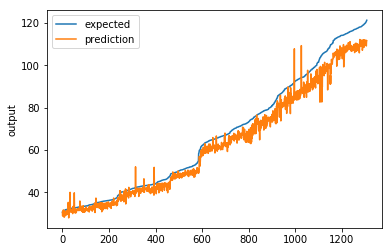

In [22]:
print(pred.shape)
print(y_test.shape)
pred_list=pred.flatten()
chart_regression(pred_list,y_test)